<a href="https://colab.research.google.com/github/mrkdh16/lottery-ticket-exploration/blob/main/LTH_OOD_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I aim to test the functional lottery ticket hypothesis presented in [Zhang et al](https://proceedings.mlr.press/v139/zhang21a/zhang21a.pdf): "[for any full network] there exists a subnetwork that can achieve better OOD and commensurate in-distribution accuracy in a comparable number of iterations when trained in isolation" using the [MNIST-1D dataset](https://github.com/greydanus/mnist1d?tab=readme-ov-file).

In [23]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master
!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-_dx55kut
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-_dx55kut
  Resolved https://github.com/greydanus/mnist1d.git to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'mnist1d' already exists and is not an empty directory.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import pickle
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from mnist1d.data import make_dataset, get_dataset_args, get_dataset

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cuda


In [27]:
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec).to(DEVICE)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

# find a mask, given some heuristic and desired sparsity
def get_mask(scores, percent_sparse):
    # scores: per-weight scores for determining which weights to drop
    # percent_sparse: how much to sparsify the model
    num_to_drop = int(percent_sparse * len(scores))
    ixs_to_drop = torch.sort(scores)[1][:num_to_drop] # sort from low score to high, select k with lowest score
    mask = torch.ones_like(scores)
    mask[ixs_to_drop] = 0
    return mask

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def accuracy(model, inputs, targets):
  preds = model(inputs).argmax(-1).cpu().numpy()
  targets = targets.cpu().numpy().astype(np.float32)
  return 100*sum(preds==targets)/len(targets)

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def get_model_args(as_dict=False):
  arg_dict = {'input_size': 40,
          'output_size': 10,
          'hidden_size': 256,
          'learning_rate': 1e-2,
          'weight_decay': 0,
          'batch_size': 100,
          'total_steps': 8000,
          'print_every': 1000,
          'eval_every': 250,
          'checkpoint_every': 1000,
          'device': 'cpu',
          'seed': 42}
  return arg_dict if as_dict else ObjectView(arg_dict)

In [15]:
if True:
    # Only run this in Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/mnist1d/"
else:
    project_dir = './'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
num_retrains = 100
sparsity_schedule = np.linspace(0, 1, num_retrains)

In [17]:
def from_pickle(path): # load something
    value = None
    with open(path, 'rb') as handle:
        value = pickle.load(handle)
    return value

trials = from_pickle(path=project_dir + 'lottery.pkl')   # load precomputed results from your Drive

In [18]:
!pip install scienceplots

In [19]:
import scienceplots
plt.style.use('science')
plt.rcParams['text.usetex'] = False

In [29]:
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000 # print never
model_args.eval_every = 100
model_args.learning_rate = 2e-2
model_args.device = DEVICE

In [20]:
def evaluate_ensemble(models, dataset, device):
  inputs = torch.tensor(dataset['x_test'], dtype=torch.float32).to(device)
  labels = torch.tensor(dataset['y_test'], dtype=torch.int64).to(device)
  test_dataset = TensorDataset(inputs, labels)
  test_loader = DataLoader(test_dataset, batch_size=model_args.batch_size, shuffle=False)

  correct_predictions = 0
  total_samples = 0

  for inputs, labels in test_loader:
    local_outputs = []
    for model in models:
      model.eval()
      local_outputs.append(model(inputs))
    avg_outputs = torch.stack(local_outputs).mean(0)
    _, predicted = torch.max(avg_outputs, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_samples += labels.size(0)

  accuracy = (correct_predictions / total_samples) * 100
  return accuracy

In [21]:
args = get_dataset_args()
data = get_dataset(args=args)

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl


In [30]:
ensemble_accs = []
for j in tqdm(range(num_retrains)):
  models = []
  for model in trials['lott_models']:
    models.append(model[j])
  ensemble_accs.append(evaluate_ensemble(models, data, DEVICE))

100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


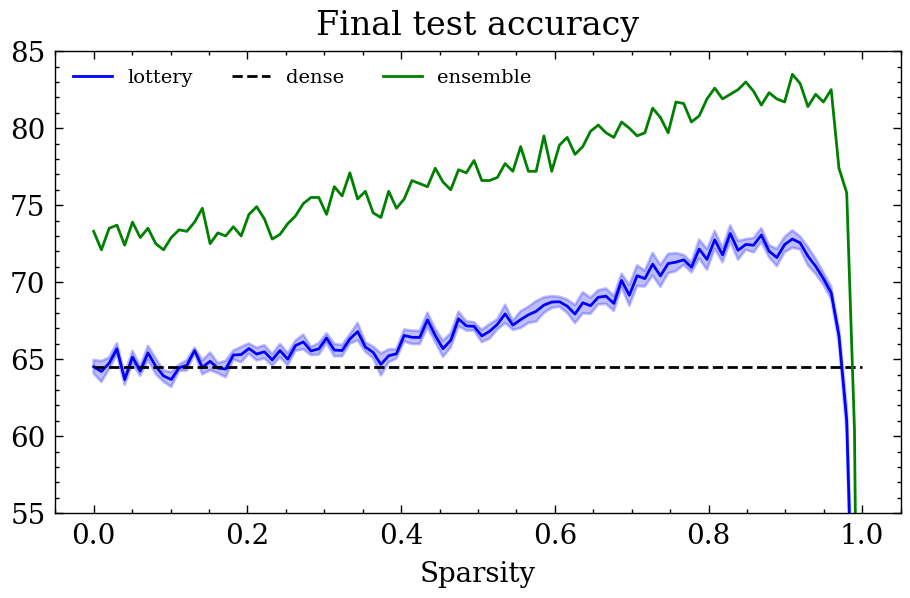

In [31]:
def average_over(trials, trial_name, key):
  ys = [trials[trial_name][i][key] for i in range(len(trials[trial_name]))]
  return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))

x = sparsity_schedule
rand_color, lott_color = 'r', 'b'
fig = plt.figure(figsize=[12,3], dpi=200)

plt.subplot(1,2,2)
y, y_err = average_over(trials, 'lott_stats', 'test_accs')
y, y_err = y[:,-1], y_err[:,-1]
plt.plot(x, y, '-', color=lott_color, label='lottery') ; plt.fill_between(x, y-y_err, y+y_err, color=lott_color, alpha=0.25)
plt.plot(x, np.ones_like(x) * y[0], 'k--', label='dense')
plt.plot(x,ensemble_accs,'-',color='green',label='ensemble')
plt.xlabel('Sparsity') ; plt.title('Final test accuracy')
plt.ylim(55, 85) #plt.ylim(70, 85)
plt.legend(fontsize=7, ncol=3, loc='upper left')

plt.show()

# os.makedirs(project_dir + 'figures/', exist_ok=True)
# fig.savefig(project_dir + 'figures/lottery.png')
# fig.savefig(project_dir + 'figures/lottery.pdf')